# Reddit API:  To predict happiness in the consumers.

In [1]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix,roc_auc_score
from scipy.sparse import csr_matrix, issparse
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.svm import SVC
import regex as re

In [ ]:
import pandas as pd
import requests
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.pipeline import Pipeline

In [2]:
final = pd.read_csv('final.csv')
wow = pd.read_csv('wow.csv')
final = final.dropna().drop_duplicates()
final['subreddit'].value_counts(normalize=True)

happy    0.538824
angry    0.461176
Name: subreddit, dtype: float64

## Cleaning

In [3]:
def get_lower(x): #Found out later that this is built into TfidfVectorizer
    return x.lower()
def get_letters(x):
    return re.sub("[^a-zA-Z]"," ",x)
final['body'] = final['body'].map(get_lower).map(get_letters)
final = final[(~final['body'].str.contains('removed'))&(~final['body'].str.contains('deleted'))]
wow['body'] = wow['body'].map(get_lower)
X = final['body']
y = final['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123)

In [4]:
final.shape

(1683, 2)

# Modeling

### Logistic Regression

In [5]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words='english')),
    ('lr',LogisticRegression(solver='liblinear'))
])
pipe_params = {
    'tvec__max_features':[1250],
    'tvec__min_df':[3],
    'tvec__max_df':[.4,.35,],
    'tvec__ngram_range':[(1,1),(1,2)]
}
gs = GridSearchCV(pipe,pipe_params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

### Scores

In [6]:
print(f'Best score is {gs.best_score_}')
print(f'Best parameters are {gs.best_params_}')
best = gs.best_estimator_
print(f'Train score is {best.score(X_train,y_train)}')
print(f'Test score is {best.score(X_test,y_test)}')

Best score is 0.9112519809825673
Best parameters are {'tvec__max_df': 0.4, 'tvec__max_features': 1250, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
Train score is 0.9540412044374009
Test score is 0.9239904988123515


In [7]:
final['log_predict'] = best.predict(X)

### False Positives?

In [8]:
cm = confusion_matrix(y_test,
                 best.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 best.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 191
False positives: 22
False negatives: 10
True positives: 198


In [9]:
roc = roc_auc_score(final['subreddit'].replace({'angry':0,'happy':1}),
              final['log_predict'].replace({'angry':0,'happy':1}))
print(f'ROC AUC: {roc}')
cm_df = pd.DataFrame(cm, columns=['Predicted Angry', 'Predicted Happy'],
                     index=['Actually Angry', 'Actually Happy'])
cm_df

ROC AUC: 0.9439199943157596


,Predicted Angry,Predicted Happy
Actually Angry,191,22
Actually Happy,10,198


### Plot to visualize how our data spread is

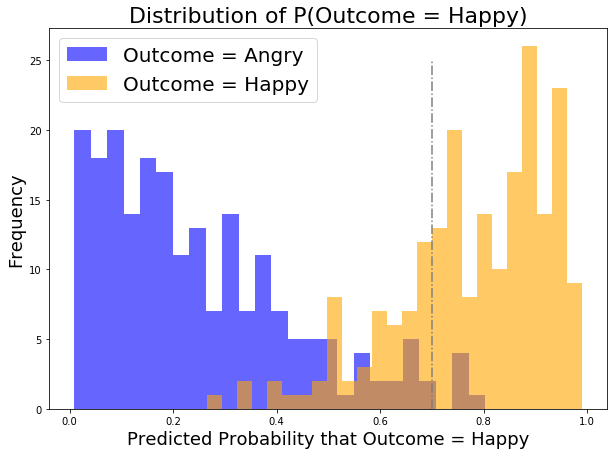

In [10]:
pred_proba = [i[1] for i in best.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 'angry']['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Angry')
plt.hist(pred_df[pred_df['true_values'] == 'happy']['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Happy')
plt.vlines(x=.7,
          ymin=0,
          ymax=25,
          color='grey',
          linestyle='dashdot')

# Label axes.
plt.title('Distribution of P(Outcome = Happy)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Happy', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20)
#Thank you Matt for the code from our lecture!
plt.savefig('log_plot.png');

In [11]:
pd.set_option('display.max_colwidth', -1)

### Since we want specificity, let's adjust all values under .7 to be angry.

In [12]:
final['log_proba'] = [i[1] for i in best.predict_proba(X)]
final['log_adjust'] = np.where(final['log_proba']<.7, 'angry', 'happy')
temp_df = pd.DataFrame(best.predict_proba(X_test))
final[final['log_adjust']=='angry'].sort_values(by='log_proba',ascending=False).head(10)

,body,subreddit,log_predict,log_proba,log_adjust
722,op zengoyano image stats width height pixels size history user date match image title karma comments status u euphorichords january x https i redd it g lawricx jpg yrs ago i shaved my head i ve struggled with depression most of my life and a lot of imposter syndrome i have been dealing with cystic acne that leaves scars on the sides of my face and i m just learning to be an adult your s are hard but i m making progress and today i feel beautiful https redd it abp zy active,happy,happy,0.699867,angry
281,world awaits congratulations on your accomplishment i am saving your post to share with my grandkids lots of work out there people,happy,happy,0.699743,angry
637,that is great i am dyslexic and i am unsure if it was an fu to the world but i forced myself to read no regrets at all we cannot live by by our weaknesses and it takes courage to overcome i actually found hidden in my dyslexia was a strength i never knew later i found malcom gladwells david and golith which is about the strengths in weaknesses there is a whole story about the greatness of dyslexia in it that was truly eye opening way to go,happy,happy,0.698453,angry
278,consider not wearing that nose ring if you need to work near high voltage transformers,happy,happy,0.697941,angry
503,thank you for this i totally get that feeling i m lonely but free today i had a wonderful time walking then just hanging out with my girls all afternoon evening without any hassle stress i m rooting for you too if you want to chat please feel free to message me,happy,happy,0.695991,angry
103,wow that s quite an achievement food means very much to me and i think it can really build relationships and communities kudos for contributing to food lit and building communities,happy,happy,0.695883,angry
628,will you get black doors and different wheels or will you paint popo on the side and mess with people,happy,happy,0.695366,angry
832,i wonder what will happen when you will stop to take them,happy,happy,0.695352,angry
1097,liars thats all they ever were,angry,happy,0.694967,angry
332,you shall henceforth be known as sparky,happy,happy,0.694258,angry


### Our new confusion matrix

In [13]:
temp_df['log_adjust'] = None
temp_df['log_adjust'] = np.where(temp_df[1]<.7,'angry','happy')

cm = confusion_matrix(y_test,
                 temp_df['log_adjust'])

roc = roc_auc_score(final['subreddit'].replace({'angry':0,'happy':1}),
              final['log_adjust'].replace({'angry':0,'happy':1}))
print(f'ROC AUC: {roc}')
cm_df = pd.DataFrame(cm, columns=['Predicted Angry', 'Predicted Happy'],
                     index=['Actually Angry', 'Actually Happy'])
cm_df

ROC AUC: 0.8903694756288191


,Predicted Angry,Predicted Happy
Actually Angry,208,5
Actually Happy,54,154


### Coefficients

In [28]:
coef = best.named_steps['lr'].coef_[0]

cols = best.named_steps['tvec'].get_feature_names()

words_df = pd.DataFrame(zip(cols,coef), columns=["words", "coefficient"])

In [29]:
words_df.sort_values('coefficient').tail(10)

,words,coefficient
86,beautiful,1.154862
470,great,1.220071
483,haha,1.289763
462,good,1.593512
66,awesome,1.657210
844,proud,1.693410
1084,thank,1.979749
203,congrats,2.016744
495,happy,2.287747
204,congratulations,2.406704


In [30]:
words_df.sort_values('coefficient').head(10)

,words,coefficient
432,fucking,-3.526763
428,fuck,-3.310606
31,angry,-2.629558
584,just,-2.545966
499,hate,-2.462121
784,people,-2.301528
964,shit,-2.080705
550,im,-1.483257
924,said,-1.451970
438,game,-1.439564


In [31]:
words_df.to_csv('word_coef.csv',index=False)

## Applying log reg to WoW reddit data

In [18]:
wow['log_proba'] = None
wow['log_proba'] = best.predict_proba(wow['body'])
wow['log_proba'] = [i[1] for i in best.predict_proba(wow['body'])]
wow['log_adjust'] = None
wow['log_adjust'] = np.where(wow['log_proba']<.7, 'angry', 'happy')
wow['log_adjust'].value_counts()

angry    757
happy    243
Name: log_adjust, dtype: int64

In [19]:
wow.to_csv('final_wow.csv',index=False)

# Disclaimer: All models below have been tested with many parameters.  Only the best parameters have been left inside the cells. Adjustment of values under 0.7 was NOT implemented in the below models as they fell short in comparison to our logistic regression model.

### K Nearest Neighbors

In [20]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words='english')),
    ('knn',KNeighborsClassifier())
])
pipe_params = {
    'knn__n_neighbors':[5],
    'tvec__max_features':[1000],
    'tvec__min_df':[100],
    'tvec__max_df':[.2,.4],
    'tvec__ngram_range':[(1,1)]
}
gs = GridSearchCV(pipe,pipe_params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [21]:
print(f'Best score is {gs.best_score_}')
print(f'Best parameters are {gs.best_params_}')
best = gs.best_estimator_
print(f'Train score is {best.score(X_train,y_train)}')
print(f'Test score is {best.score(X_test,y_test)}')

Best score is 0.8129952456418383
Best parameters are {'knn__n_neighbors': 5, 'tvec__max_df': 0.4, 'tvec__max_features': 1000, 'tvec__min_df': 100, 'tvec__ngram_range': (1, 1)}
Train score is 0.8343898573692552
Test score is 0.8218527315914489


In [22]:
final['knn_predict'] = best.predict(X)

In [23]:
cm = confusion_matrix(y_test,
                 best.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 best.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 156
False positives: 57
False negatives: 18
True positives: 190


In [24]:
roc = roc_auc_score(final['subreddit'].replace({'angry':0,'happy':1}),
              final['knn_predict'].replace({'angry':0,'happy':1}))
print(f'ROC AUC: {roc}')
cm_df = pd.DataFrame(cm, columns=['Predicted Angry', 'Predicted Happy'],
                     index=['Actually Angry', 'Actually Happy'])
cm_df

ROC AUC: 0.8227277248827625


,Predicted Angry,Predicted Happy
Actually Angry,156,57
Actually Happy,18,190


In [25]:
wow['knn_predict'] = best.predict(wow['body'])
wow['knn_predict'].value_counts()

happy    782
angry    218
Name: knn_predict, dtype: int64

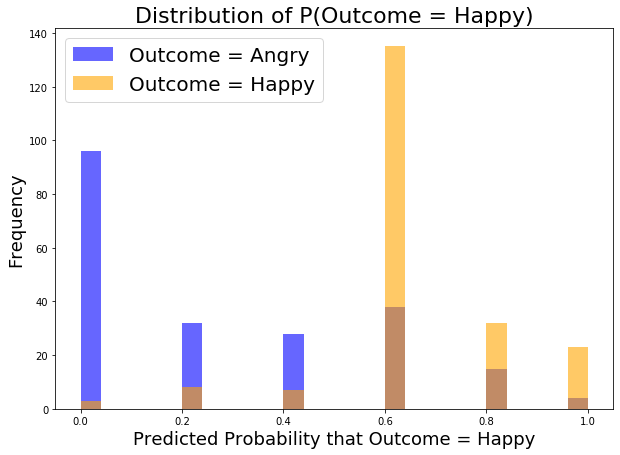

In [26]:
pred_proba = [i[1] for i in best.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 'angry']['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Angry')
plt.hist(pred_df[pred_df['true_values'] == 'happy']['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Happy')

# Label axes.
plt.title('Distribution of P(Outcome = Happy)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Happy', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);
#Thank you Matt for the code from our lecture!

### Random forest (tree and bagging included)

In [27]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words='english')),
    ('rf',RandomForestClassifier())
])
pipe_params = {
    'rf__n_estimators':[1,100],
    'rf__max_features':[None,'auto'],
    'rf__max_depth':[20],
    'tvec__max_features':[800],
    'tvec__min_df':[3],
    'tvec__max_df':[.85],
    'tvec__ngram_range':[(1,1),(1,2)]
}
gs = GridSearchCV(pipe,pipe_params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [28]:
print(f'Best score is {gs.best_score_}')
print(f'Best parameters are {gs.best_params_}')
best = gs.best_estimator_
print(f'Train score is {best.score(X_train,y_train)}')
print(f'Test score is {best.score(X_test,y_test)}')

Best score is 0.8882725832012678
Best parameters are {'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__n_estimators': 100, 'tvec__max_df': 0.85, 'tvec__max_features': 800, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Train score is 0.938985736925515
Test score is 0.8907363420427553


In [29]:
final['rf_predict'] = best.predict(X)

In [30]:
cm = confusion_matrix(y_test,
                 best.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 best.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 179
False positives: 34
False negatives: 12
True positives: 196


In [31]:
roc = roc_auc_score(final['subreddit'].replace({'angry':0,'happy':1}),
              final['rf_predict'].replace({'angry':0,'happy':1}))
print(f'ROC AUC: {roc}')
cm_df = pd.DataFrame(cm, columns=['Predicted Angry', 'Predicted Happy'],
                     index=['Actually Angry', 'Actually Happy'])
cm_df

ROC AUC: 0.9217791672587752


,Predicted Angry,Predicted Happy
Actually Angry,179,34
Actually Happy,12,196


In [32]:
wow['rf_predict'] = best.predict(wow['body'])
wow['rf_predict'].value_counts()

happy    790
angry    210
Name: rf_predict, dtype: int64

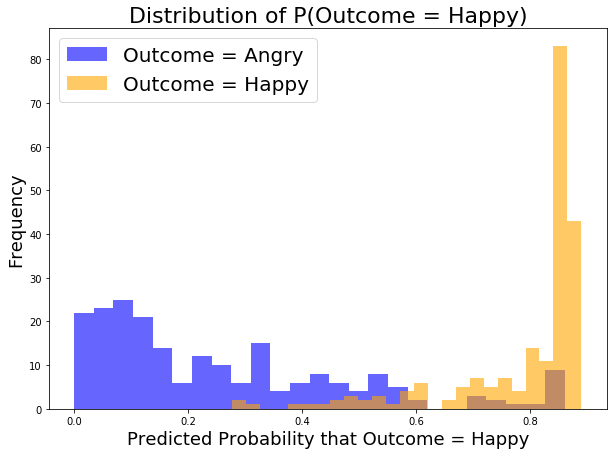

In [33]:
pred_proba = [i[1] for i in best.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 'angry']['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Angry')
plt.hist(pred_df[pred_df['true_values'] == 'happy']['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Happy')

# Label axes.
plt.title('Distribution of P(Outcome = Happy)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Happy', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);
#Thank you Matt for the code from our lecture!

### Naive Bayes (Gaussian)

In [34]:
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [35]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words='english')),
    ('to_dense', DenseTransformer()), 
    ('gnb',GaussianNB())
])
pipe_params = {
    'tvec__max_features':[1300,1400],
    'tvec__min_df':[2,3],
    'tvec__max_df':[.6,.7,],
    'tvec__ngram_range':[(1,1),(1,2)]
}
gs = GridSearchCV(pipe,pipe_params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [36]:
print(f'Best score is {gs.best_score_}')
print(f'Best parameters are {gs.best_params_}')
best = gs.best_estimator_
print(f'Train score is {best.score(X_train,y_train)}')
print(f'Test score is {best.score(X_test,y_test)}')

Best score is 0.8240887480190174
Best parameters are {'tvec__max_df': 0.6, 'tvec__max_features': 1300, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Train score is 0.9619651347068146
Test score is 0.8693586698337292


In [37]:
final['nb_predict'] = best.predict(X)

In [38]:
cm = confusion_matrix(y_test,
                 best.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 best.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 188
False positives: 25
False negatives: 30
True positives: 178


In [39]:
roc = roc_auc_score(final['subreddit'].replace({'angry':0,'happy':1}),
              final['nb_predict'].replace({'angry':0,'happy':1}))
print(f'ROC AUC: {roc}')
cm_df = pd.DataFrame(cm, columns=['Predicted Angry', 'Predicted Happy'],
                     index=['Actually Angry', 'Actually Happy'])
cm_df

ROC AUC: 0.9364779025152765


,Predicted Angry,Predicted Happy
Actually Angry,188,25
Actually Happy,30,178


In [40]:
wow['nb_predict'] = best.predict(wow['body'])
wow['nb_predict'].value_counts()

angry    549
happy    451
Name: nb_predict, dtype: int64

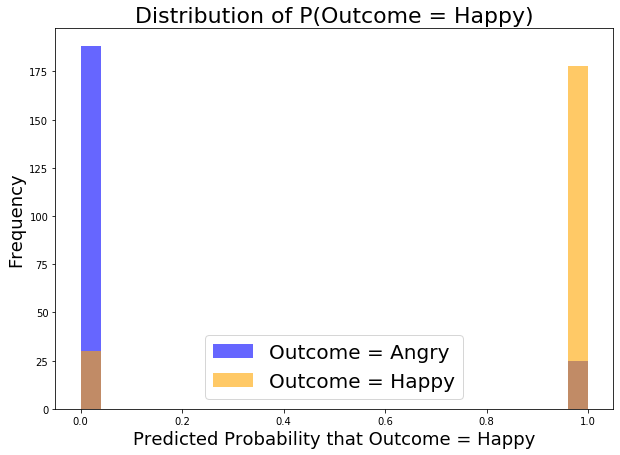

In [41]:
pred_proba = [i[1] for i in best.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 'angry']['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Angry')
plt.hist(pred_df[pred_df['true_values'] == 'happy']['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Happy')

# Label axes.
plt.title('Distribution of P(Outcome = Happy)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Happy', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);
#Thank you Matt for the code from our lecture!

## Looking at some values...

In [42]:
final

,body,subreddit,log_predict,log_proba,log_adjust,knn_predict,rf_predict,nb_predict
0,congratulations welcome to parenthood i wish him a healthy and happy childhood,happy,happy,0.934858,happy,happy,happy,happy
1,congratulations there is no greater blessing no greater responsibility and no greater source of worry angst and love to be found,happy,happy,0.890793,happy,happy,happy,happy
2,indeed it s the small things that make a difference,happy,happy,0.729612,happy,happy,happy,happy
3,so happy for all of you,happy,happy,0.966244,happy,happy,happy,happy
4,oh man i tutored for a couple years in college mostly esl and i always felt like it was so worth it not sure i made much of a difference but every bit that could help always felt worth it,happy,happy,0.779127,happy,happy,happy,happy
...,...,...,...,...,...,...,...,...
1768,i started besting him over a stupid video game and now i have no friends and no one i care about he was the only good thing in my life right now,angry,angry,0.267932,angry,happy,angry,angry
1769,i was really close with him and someone i knew introduced me to him because she kept telling me joe me and him were sooo similar in personality and attitude so i was like meh who cares anyways he s probably nobody special then i met him by accident and got introduced to him and we became instant bffs like he was my best friend and rn i hate him so much so we became very good friends and then he got introduced to one of my other only female friends she wasn t really my friend and they slowly became closer it really wasn t fair at all tbh i knew him first and this girl is like and he s my age so and they re so weird and flirty and creepy and he used to tell me he thinks she s weird honestly i hate him so much and made sure he wasn t left on any of my social media cuz he ghosted me first without reason i m really done with fake people,angry,angry,0.326170,angry,angry,angry,angry
1770,i hate us i d go so far as to say i d kill some of us obviously i m not gonna do that but i hate us that much just fuck everyone humans are scum,angry,angry,0.096049,angry,angry,angry,angry
1771,i love my mum like every other normal person but zzz i fucking hate myself im so fucking fat and ugly and i fucking hate eating it makes me feel like shit i wish i could just eat air for the rest of my fucking life but no i just end up binge eating every fucking night and gaining more weight im fat and ugly and i hate it now there are alot of fucking things my mum does that makes me ultra angry but this definitely is up there when it comes to things i fucking hate i have a fucking diet i try to follow but she vuys much food and expects me to eat that tucking shit everyday i cant even finish it she buys so much and whenever i say im fat she fucking starts talking about herself being fat and that teenagers cant get fat fuck you annoying betchh ugh unfortunatelt teenagers can indeed get fat if yoy force them to eat meals a day and whenever i even mentiln a diet she just doesnt fucking an to hear it even if its completely fucking healthy like eat fruits or only eat meals avoid supper shitlike thag and no ughhh k hage her for this also cuz she is so annoying in public its so embaressing i hate that i hate her but shes making me feel like this so too fuckin bad ugh deleting soon but im just angry and need to vent probablg going to cringe at this and regret it later but im too angry to think now,angry,angry,0.018089,angry,angry,angry,angry


In [43]:
final.to_csv('final_predicts_4_models.csv',index=False)